In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, precision_recall_curve, precision_score, recall_score, f1_score
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold

%matplotlib inline

In [2]:
!wget https://archive.ics.uci.edu/static/public/222/bank+marketing.zip
!unzip -o bank+marketing.zip 
!unzip -o bank.zip

--2024-10-21 21:03:14--  https://archive.ics.uci.edu/static/public/222/bank+marketing.zip
Loaded CA certificate '/etc/ssl/certs/ca-certificates.crt'
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘bank+marketing.zip.2’

bank+marketing.zip.     [       <=>          ] 999.85K   589KB/s    in 1.7s    

2024-10-21 21:03:17 (589 KB/s) - ‘bank+marketing.zip.2’ saved [1023843]

Archive:  bank+marketing.zip
 extracting: bank.zip                
 extracting: bank-additional.zip     
Archive:  bank.zip
  inflating: bank-full.csv           
  inflating: bank-names.txt          
  inflating: bank.csv                


In [3]:
df = pd.read_csv('bank-full.csv', delimiter=';')
df.head(2)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no


In [4]:
base = [
    'age', 'job', 'marital', 'education', 'balance', 'housing', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays', 'previous', 'poutcome', 'y'
]
numerical = [
    'age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous'
]

df = df[base]
df.head(2)

,age,job,marital,education,balance,housing,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,2143,yes,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,29,yes,unknown,5,may,151,1,-1,0,unknown,no


In [5]:
df['y'] = (df['y'] == 'yes').astype(int)

df_train_full, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_train_full, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.pop('y').values
y_val = df_val.pop('y').values
y_test = df_test.pop('y').values

1. Numerical variable with the highest AUC

In [6]:
# print(f'Feature \tAUC')
auc_scores = []

for var in numerical:
    auc = roc_auc_score(y_train, df_train[var])
    # Invert if AUC < 0.5
    if auc < 0.5:
        auc = roc_auc_score(y_train, -df_train[var])
    # print(f'{var:<7} \t{auc:.3f}')
    auc_scores.append(auc)

res = list(zip(numerical, auc_scores))
res.sort(key=lambda x:x[1], reverse=True)

print(res[0][0], round(res[0][1], 3))

duration 0.815


2. AUC of the model on the validation dataset

In [7]:
dv = DictVectorizer(sparse=False)

train_dict = df_train.to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

val_dict = df_val.to_dict(orient='records')
X_val = dv.transform(val_dict)

model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)

# y_val_pred = model.predict(X_val)
y_val_pred = model.predict_proba(X_val)[:, 1]
auc_score = roc_auc_score(y_val, y_val_pred)

print(round(auc_score, 3))

0.9


3. At which threshold precision and recall curves intersect?

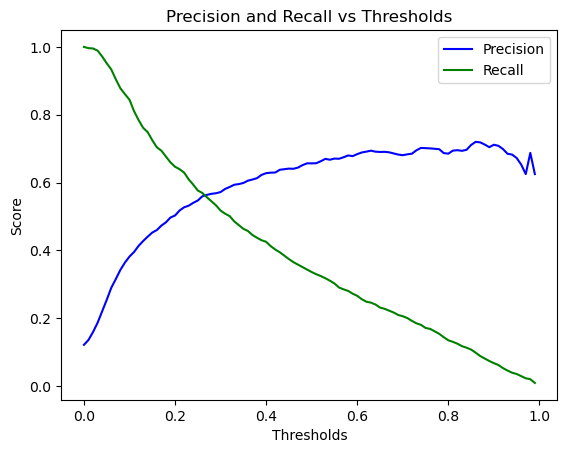

In [8]:
thresholds = np.arange(0, 1, 0.01)
precisions, recalls = np.array([]), np.array([])

# print(f'Threshold\tPrecision\tRecall')

for threshold in thresholds:
    predicted_positive = (y_val_pred >= threshold)
    predicted_negative = (y_val_pred < threshold)
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)

    tp = (actual_positive & predicted_positive).sum()
    fp = (predicted_positive & actual_negative).sum()
    fn = (predicted_negative & actual_positive).sum()
    
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)

    # predicted_positive = (y_val_pred >= threshold).astype(int)
    # precision = precision_score(y_val, predicted_positive)
    # recall = recall_score(y_val, predicted_positive)

    # print(f'{round(threshold, 2)}\t{round(precision, 3)}\t{round(recall, 3)}')

    precisions = np.append(precisions, precision)
    recalls = np.append(recalls, recall)

# thresholds = np.arange(0, 1, 0.01)
# precisions, recalls, thresholds = precision_recall_curve(y_val, y_val_pred_proba)

plt.plot(thresholds, precisions, label='Precision', color='blue')
plt.plot(thresholds, recalls, label='Recall', color='green')
plt.xlabel('Thresholds')
plt.ylabel('Score')
plt.title('Precision and Recall vs Thresholds')
plt.legend()
plt.show()

In [9]:
differences = np.abs(np.array(precisions) - np.array(recalls))
threshold_at_intersection = thresholds[np.argmin(differences)]
print(round(threshold_at_intersection, 3))

0.27


4. At which threshold F1 is maximal?

In [10]:
print('Threshold\tF1 Value')

"""
f1_results = []

for threshold, precision, recall in zip(thresholds, precisions, recalls):
    f1_result = (2 * precision * recall) / (precision + recall)
    # predicted_positive = (y_val_pred >= threshold).astype(int)
    # f1_result = f1_score(y_val, predicted_positive)
    
    f1_results.append(f1_result)

res = list(zip(thresholds, f1_results))
res.sort(key=lambda x:x[1], reverse=True)

print(f'{round(res[0][0], 3):<10}\t{round(res[0][1], 3)}')
"""

f1_results = np.where(precisions + recalls > 0, 2 * (precisions * recalls) / (precisions + recalls), 0)
max_f1_index = np.argmax(f1_results)

print(f'{round(thresholds[max_f1_index], 3):<10}\t{round(f1_results[max_f1_index], 3)}')

Threshold	F1 Value
0.22      	0.574


5. Standard deviation of the scores across different folds

In [11]:
def train(df, y_train, C=1.0):
    dicts = df.to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X = dv.fit_transform(dicts)
    
    model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
    model.fit(X, y_train)
    return dv, model

def predict(df, dv, model):
    dicts = df.to_dict(orient='records')
    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]
    # y_pred = model.predict(X)
    
    return y_pred

In [12]:
kfold = KFold(n_splits=5, shuffle=True, random_state=1)
auc_scores = []

for train_idx, val_idx in kfold.split(df_train_full):
    df_train = df_train_full.iloc[train_idx]
    df_val = df_train_full.iloc[val_idx]

    y_train = df_train['y'].values
    y_val = df_val['y'].values

    dv, model = train(df_train, y_train)
    y_pred = predict(df_val, dv, model)
    
    auc = roc_auc_score(y_val, y_pred)
    auc_scores.append(auc)

print(round(np.std(auc_scores), 4))

0.0


6. Which C leads to the best mean score?

In [13]:
print('C\tAUC')

for C in [0.000001, 0.001, 1]:
    auc_scores = []
    kfold = KFold(n_splits=5, shuffle=True, random_state=1)

    for train_idx, val_idx in kfold.split(df_train_full):
        df_train = df_train_full.iloc[train_idx]
        df_val = df_train_full.iloc[val_idx]
    
        y_train = df_train.pop('y').values
        y_val = df_val.pop('y').values
    
        dv, model = train(df_train, y_train, C)
        y_pred = predict(df_val, dv, model)
        
        auc = roc_auc_score(y_val, y_pred)
        auc_scores.append(auc)

    print(f'{C}\t{round(np.std(auc_scores), 3)}')

C	AUC
1e-06	0.009
0.001	0.007
1	0.006
